# Transforms

> Custom PyTorch batch transforms

In [1]:
#| default_exp transforms

In [2]:
%load_ext autoreload
%autoreload 2

In [32]:
#| export
from pathlib import Path

import torch
from torchvision import transforms as T

In [38]:
#|eval: false
import matplotlib.pyplot as plt
from lssm.loading import load_ossl
from lssm.preprocessing import ToAbsorbance, ContinuumRemoval
from lssm.dataloaders import SpectralDataset, get_dls
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [17]:
#| export
class GADFTfm(): 
    """
    Transform batch of spectra S (B, 1, len(S)) into their Grammian Difference Matrix Field (GADF) of shape (B, 1, H, W)
    
    Notes:
    https://arxiv.org/pdf/1506.00327.pdf
    """
    def __init__(self, neg=True):
        self.neg = neg
        
    def rescale(self, x):
        m = torch.min(x, dim=-1, keepdim=True).values
        M = torch.max(x, dim=-1, keepdim=True).values
        return ((x - M) + (x - m)) / (M - m) if self.neg else (x - m) / (M - m)

    def __call__(self, 
                 b # Batch of spectra S: (B, 1, len(S))
                 ): 
        x, y, *metadata = b
        X, I = self.rescale(x), torch.ones_like(x)
        K = torch.sqrt(I - torch.square(X))
        x = (torch.matmul(torch.transpose(K, 1, 2), X) - 
             torch.matmul(torch.transpose(X, 1, 2), K)).unsqueeze_(1)
        return x, y, *metadata

Example:

In [25]:
#|eval: false
fname_ossl = Path.home() / 'pro/data/ossl/gcs_version/ossl_all_L0_v1.2.csv.gz'
analytes = 'k.ext_usda.a725_cmolc.kg'

# Load dataset
data = load_ossl(fname_ossl, analytes, spectra_type='visnir')
X, y, X_names, smp_idx, ds_name, ds_label = data

In [26]:
#|eval: false

# Transform
X = Pipeline([('to_abs', ToAbsorbance()), 
              ('cr', ContinuumRemoval(X_names))]).fit_transform(X)

# Train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.2,
                                                      stratify=ds_name, 
                                                      random_state=41)

# Get PyTorch datasets
train_ds, valid_ds = [SpectralDataset(X, y, ) 
                      for X, y, in [(X_train, y_train), (X_valid, y_valid)]]

# Then PyTorch dataloaders
dls = get_dls(train_ds, valid_ds, bs=32)

first_batch = next(iter(dls.train))

100%|██████████| 3725/3725 [00:01<00:00, 2859.30it/s]


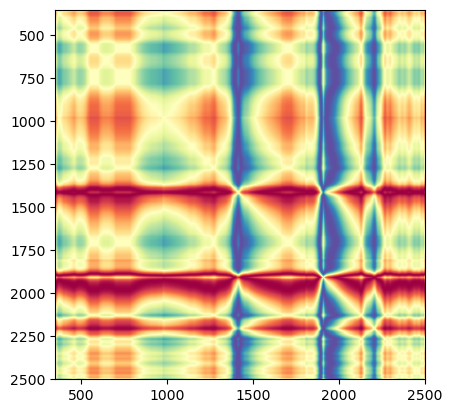

In [28]:
#|eval: false
plt.imshow(GADFTfm()(first_batch)[0][0].squeeze().cpu(),
           cmap='Spectral', 
           origin='upper', extent=[X_names[0], X_names[-1], X_names[-1], X_names[0]]);

In [41]:
#| export
def _resizeTfm(b, size=224):
    "Resize image"
    x, y, *metadata  = b
    return T.Resize(size)(x), y, *metadata

torch.Size([32, 1, 224, 224])


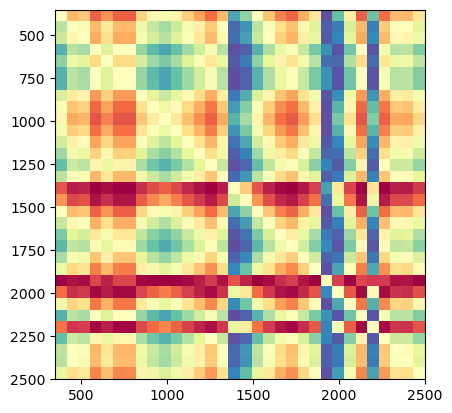

In [39]:
#|eval: false
print(_resizeTfm(GADFTfm()(first_batch))[0].shape)
plt.imshow(_resizeTfm(GADFTfm()(first_batch), size=32)[0][0].squeeze().cpu(),
           cmap='Spectral', 
           origin='upper', extent=[X_names[0], X_names[-1], X_names[-1], X_names[0]]);